In [6]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import cv2
import time
import torch
import joblib
import shutil
import colorsys
import argparse
import numpy as np
from tqdm import tqdm
from multi_person_tracker import MPT
from torch.utils.data import DataLoader

from lib.models.vibe import VIBE_Demo
from lib.utils.renderer import Renderer
from lib.dataset.inference import Inference
from lib.utils.smooth_pose import smooth_pose
from lib.data_utils.kp_utils import convert_kps
from lib.utils.pose_tracker import run_posetracker

from lib.utils.demo_utils import (
    download_youtube_clip,
    smplify_runner,
    convert_crop_coords_to_orig_img,
    convert_crop_cam_to_orig_img,
    prepare_rendering_results,
    video_to_images,
    images_to_video,
    download_ckpt,
)

import matplotlib.pyplot as plt
import ml_collections
MIN_NUM_FRAMES = 25

In [7]:
video_file = '/home/epinyoan/dataset/casia-b/dataset_b/Datset-B-1/video/052-nm-03-144.avi'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
image_folder, num_frames, img_shape = video_to_images(video_file, return_info=True)
print(f'Input video number of frames {num_frames}')
orig_height, orig_width = img_shape[:2]

# run multi object tracker
mot = MPT(
    device=device,
    batch_size=12,
    display=False,
    detector_type='yolo',
    output_format='dict',
    yolo_img_size=416,
)
tracking_results = mot(image_folder)
# ========= Define VIBE model ========= #
model = VIBE_Demo(
    seqlen=16,
    n_layers=2,
    hidden_size=1024,
    add_linear=True,
    use_residual=True,
).to(device)

# ========= Load pretrained weights ========= #
pretrained_file = download_ckpt(use_3dpw=True)
ckpt = torch.load(pretrained_file)
model.load_state_dict(ckpt['gen_state_dict'], strict=False)
model.eval()
print(f'Loaded pretrained weights from \"{pretrained_file}\"')

Running "ffmpeg -i /home/epinyoan/dataset/casia-b/dataset_b/Datset-B-1/video/052-nm-03-144.avi -f image2 -v error ./output/sample_video/052-nm-03-144_avi/%06d.png"
Images saved to "./output/sample_video/052-nm-03-144_avi"
Input video number of frames 101


 11%|█         | 1/9 [00:00<00:01,  6.11it/s]

Running Multi-Person-Tracker


100%|██████████| 9/9 [00:01<00:00,  5.50it/s]


Finished. Detection + Tracking FPS 61.53
=> loaded pretrained model from 'data/vibe_data/spin_model_checkpoint.pth.tar'
Loaded pretrained weights from "data/vibe_data/vibe_model_w_3dpw.pth.tar"


In [8]:
person_id = list(tracking_results.keys())[0]
bboxes = tracking_results[person_id]['bbox']
frames = tracking_results[person_id]['frames']
dataset = Inference(
    image_folder=image_folder,
    frames=frames,
    bboxes=bboxes,
    joints2d=None,
    scale=1.1,
)
bboxes = dataset.bboxes
frames = dataset.frames
dataloader = DataLoader(dataset, batch_size=450, num_workers=16)
with torch.no_grad():
    for batch in dataloader:
        batch = batch.unsqueeze(0)
        batch = batch.to(device)
        batch_size, seqlen = batch.shape[:2]
        output = model(batch)[-1]

In [9]:
pred_cam, pred_verts, pred_pose, pred_betas, pred_joints3d, smpl_joints2d, norm_joints2d = [], [], [], [], [], [], []
pred_cam.append(output['theta'][:, :, :3].reshape(batch_size * seqlen, -1))
pred_cam = torch.cat(pred_cam, dim=0)
pred_cam = pred_cam.cpu().numpy()
orig_cam = convert_crop_cam_to_orig_img(
    cam=pred_cam,
    bbox=bboxes,
    img_width=orig_width,
    img_height=orig_height
)

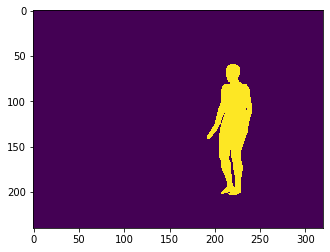

In [10]:
verts_ = output['verts'].reshape(batch_size * seqlen, -1, 3)
renderer = Renderer(resolution=(orig_width, orig_height), orig_img=True, wireframe=False)
img = renderer.render(
    np.zeros((240, 320, 3)),
    verts_[20].cpu().numpy(),
    cam=orig_cam[20],
    color=[1,0,0],
    mesh_filename=None,
)

plt.imshow(img.astype(np.int).squeeze(axis=2))

### Try to run DEODR with SMPL data [not working yet]

In [11]:
depth_image = img.copy().astype(np.float)
depth_image = depth_image.squeeze()
temp = depth_image[:,100:].copy()
depth_image[:,100:] = 0
depth_image[:,:-100] = temp

In [12]:
deodr.__file__

'/home/epinyoan/.local/lib/python3.6/site-packages/deodr/__init__.py'

In [13]:
import datetime
import glob
import json
import os
import time

import cv2

import deodr
from deodr import ColoredTriMesh

from imageio import imsave

import matplotlib.pyplot as plt

import numpy as np
from deodr.pytorch import MeshDepthFitter
from lib.models.smpl import get_smpl_faces

In [14]:
vertices = verts_[20].cpu().numpy().astype(np.double)
faces = get_smpl_faces().astype(np.int32)
euler_init = np.array([0.1, 0.1, 0.1])
translation_init = np.zeros(3)

hand_fitter = MeshDepthFitter(
    vertices, faces, euler_init, translation_init, cregu=1000
)
hand_fitter.set_image(depth_image, focal=241, distortion=[1, 0, 0, 0, 0])
hand_fitter.set_max_depth(1)
hand_fitter.set_depth_scale(2)

In [17]:
energy, synthetic_depth, diff_image = hand_fitter.step()
diff_image.min(), diff_image.max()

Energy=73150.000000 : EData=73150.000000 E_rigid=-0.000000


(0.0, 1.0)

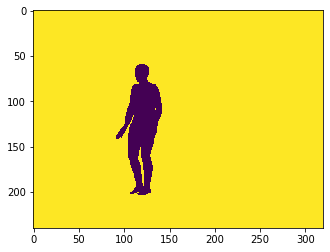

In [18]:
plt.imshow(diff_image)